# Rasters

This notebook is all about rasters. We'll start with an introduction to `rasterio`, the main python library for working with raster data. We'll see how rasters are made in rasterio and how that corresponds to our discussion in class on Tuesday about how raster data are represented. We'll then talk about how band algebra can be implemented using `rasterio` and `numpy`, a library designed for working with arrays. Finally, we'll see how we can mask a raster in two different ways, by applying a function to the array part of the raster and by looking for cells that intersect a geometry.

First let's start by importing the two libraries mentioned above.

In [1]:
# Both of these shorthands are standard
import rasterio as rio
import numpy as np 

Here's the basic info on [rasterio](https://rasterio.readthedocs.io/en/stable/quickstart.html). The relevant section here is "Creating data". We'll do something similar. As we learned in class on Tuesday, a raster is basically an array, the transformation matrix, and a CRS. The first and simplest component is the array, and `numpy` is the main python library for working with arrays. The main class here is the `numpy.array` ([documentation here](https://numpy.org/doc/stable/reference/generated/numpy.array.html)). As I mentioned in class, a 2D array is basically a list of lists and indeed, we can make an array that way.

In [2]:
arr1 = np.array(
    [
        [1, 2, 3], # First row
        [4, 5, 6] # Second row
    ]
)
arr1

array([[1, 2, 3],
       [4, 5, 6]])

This array has 2 rows and 3 columns, i.e., it is a 2x3 array. We can see that by looking at it's `shape` attribute.

In [3]:
arr1.shape

(2, 3)

We can make some bigger arrays that will be useful for examples using some particular numpy functions, like `np.ones` or `np.zeros`. We'll use `np.random.rand`, which chooses random numbers between zero and one ([documentation here](https://numpy.org/devdocs/reference/random/generated/numpy.random.rand.html)). We supply the shape we want and get a random array. For example, we can make another 2x3 array like this:

In [6]:
r1 = np.random.rand(2,3)
r1

array([[0.81815657, 0.68716121, 0.12426417],
       [0.52477151, 0.66111524, 0.87972112]])

In [7]:
r1.shape

(2, 3)

Let's make a bigger array (e.g. 100x100) to use to make an example raster.

In [8]:
r100 = np.random.rand(100,100)
r100

array([[0.80350451, 0.61245227, 0.60643152, ..., 0.81209464, 0.24844138,
        0.11347132],
       [0.63133149, 0.67891704, 0.58801557, ..., 0.87672574, 0.47005701,
        0.4178161 ],
       [0.5241157 , 0.33181315, 0.94653254, ..., 0.05103059, 0.90172557,
        0.94390168],
       ...,
       [0.86752995, 0.70735499, 0.96286235, ..., 0.86961474, 0.32379787,
        0.13362421],
       [0.66644665, 0.10616329, 0.8287811 , ..., 0.53629294, 0.66720467,
        0.28447988],
       [0.75728535, 0.68492422, 0.10671033, ..., 0.76027473, 0.07498035,
        0.23453324]], shape=(100, 100))

Now that we have the array part of our raster, let's make the transformation matrix. As we mentioned in class on Tuesday, this is a 2x3 matrix where the right-most column gives the coordinates of the top left of the array and the other four elements tell us about the orientation of the array and how large a space it occupies. Let's say these six numbers are 

a  b  c

d  e  f

Then (c,f) is the coodinate of the top-left. Importantly, CRSs differ in whether the first number corresponds to East-West or North-South, so make sure to check!

The numbers a and b tell us about how we move in space as we move horizontally on the array. Moving one unit to the right in the array corresponds to moving a units in the direction represented by the first component in the CRS and b units in the second direction. Similarly, moving one unit down in the array corresponds to moving d units in the first direction in the CRS, and e units in the second direction. 

We make a transformation matrix by supplying those six numbers to a class `rasterio.transform.Affine`. Here, we'll make a transformation matrix that corrsponds exactly to the coordinate system that is implicit in the array. As we move one column to the right, we move 1 unit to the right and as we move one row down we move one unit down. 

In [17]:
from rasterio.transform import Affine

t1 = Affine(
    1, 0, 0,
    0, -1, 0
)
t1

Affine(1.0, 0.0, 0.0,
       0.0, -1.0, 0.0)

If we plot a raster using that transformation matrix, you'll see that it looks just like if we didn't assign it any spatial information. When we plotted things before, we used built-in `plot` methods from geopandas and shapely. Unfortunately, for most cases we can't really do something as simple as that for rasters. Instead, lets import the standard python plotting library `matplotlib.pyplot`.

In [11]:
import matplotlib.pyplot as plt # another standard shorthand

`matplotlib` has a horribly clunky syntax, so it can be painful to use sometimes. I recommend looking into [seaborn](https://seaborn.pydata.org/) (or using AI to help nail down the code for a particular vizualization). But for our purposes here, `matplotlib` should be fine.

Let's first just plot the array with no extra information using `plt.imshow`, which treats 2D arrays (or 3D arrays with 3 bands) as images.

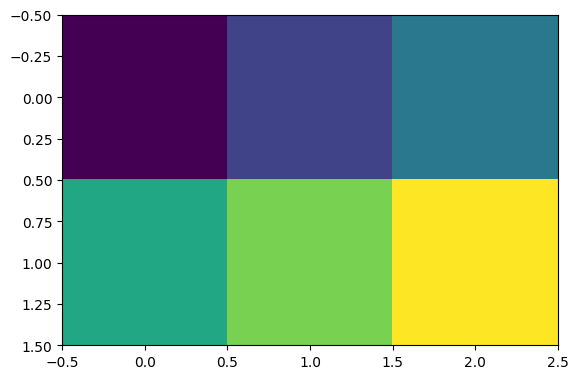

In [14]:
plt.imshow(arr1)

For that really basic array, we can see it plotted low values as darker blue-green colors and high values as brighter green-yellow. Now let's try the big array.

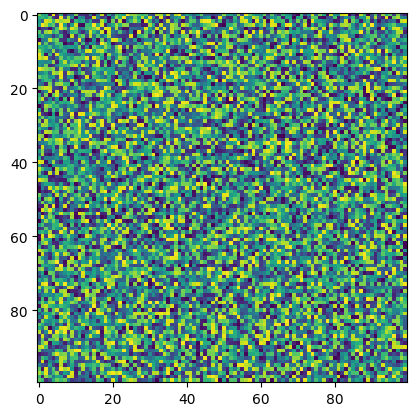

In [16]:
plt.imshow(r100)

Also note that 0 is at the top of the y-axis and larger numbers further down, corresponding to the row numbers.

Now let's try making a raster version of this array that produces a similar plot. This is another case where the particular CRS we use doesn't matter, so let's just use `EPSG:4326` (WGS84). To make a raster, we have to make a new file with the necessary metadata and save the raster there. Then we can re-open it and plot it.

In [19]:
new_dataset = rio.open(
    './r100.tif', # Filename. Here, "./" is saying "save in the current directory" and ".tif" is the geotif file extension
    'w', # This says, "open this file in write mode" so we can add data to it
    driver='GTiff', # While geotif is the most common raster format, there are others, so this says make the file a geotif
    height=r100.shape[0], # We need to define the size of the array associated with this raster, which we can get from the shape attribute
    width=r100.shape[1],
    count=1, # This is the number of bands. Here we're just doing one
    dtype=r100.dtype, # This asks what kind of data will be put in the array, which again we can take directly from the array.
    crs='EPSG:4326', # We know what this is :)
    transform=t1 # And finally, we set the transformation matrix
)

/Users/ferguson7/venv/sda/lib/python3.13/site-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


We even got a warning saying this is just `Affine.identity`, which is exactly what we wanted! So we're on the right track. Let's now write the array data to the raster using the `write` method.

In [20]:
new_dataset.write(r100,1) # first argument: data to write, second argument: which band to write to (1-indexed!)

And now we're done making the raster so we can close it! After we close it, we can re-open it in read mode and start using it for plotting.

In [21]:
new_dataset.close()

r100_r = rio.open("./r100.tif")
r100_r

<open DatasetReader name='./r100.tif' mode='r'>

We can see some of the things we added by looking at `r100_r`'s `crs` and `transform` attributes.

In [22]:
r100_r.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [23]:
r100_r.transform

Affine(1.0, 0.0, 0.0,
       0.0, -1.0, 0.0)

Looks good! Now let's try plotting `rasterio`-style ([described here](https://rasterio.readthedocs.io/en/latest/topics/plotting.html)). We can use `rasterio.plot.show` to make sure we show the proper spatial information we've incorporated (and make an RGB image if we have 3 bands).

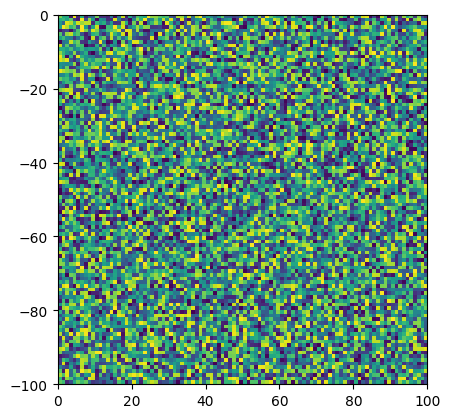

<Axes: >

In [24]:
from rasterio.plot import show

show(r100_r)

It's somewhat hard to tell because of the random data, but this is indeed the same plot as we saw before. Notice, however, now the y-axis goes from -100 to 0. That's because we said we go down 1 unit for each row we go down, and we start in the top-left at 0.

What happens if we use a transform that includes rotation? Let's remake the raster with a transform with non-zero b and d elements.

In [34]:
t2 = Affine(
    1, -0.25, 0,
    -0.5, -1, 0
)
t2

Affine(1.0, -0.25, 0.0,
       -0.5, -1.0, 0.0)

And now another geotiff

In [35]:
new_dataset = rio.open(
    './r100_2.tif', # change the filename
    'w', # Then a lot of stuff stays the same
    driver='GTiff', 
    height=r100.shape[0],
    width=r100.shape[1],
    count=1, 
    dtype=r100.dtype,
    crs='EPSG:4326',
    transform=t2 # but we use our new transformation matrix
)
new_dataset.write(r100,1)
new_dataset.close()

And let's open it and plot it.

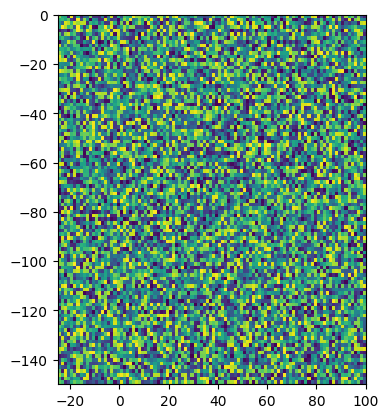

<Axes: >

In [36]:
r100_r2 = rio.open("./r100_2.tif")
show(r100_r2)

That may not be what you expected! It turns out `rasterio` prefers to keep the array oriented as it was when plotting, which is confusing! Put another way, `rasterio` doesn't assume it knows how to stretch a given pixel, so it preserves the shape of raster. I have been tricked by this many times. We can open it in QGIS to see that it is indeed rotated though.

## Band algebra

Given that the data part of rasters are just arrays, it's quite simple to perform band algebra: we just do operations on the arrays! Let's make a three-band raster, similar to our 1-band example.

In [53]:
r100_3 = np.random.rand(100,100,3)
new_dataset = rio.open(
    './r100_3d.tif', 
    'w', 
    driver='GTiff', 
    height=r100_3.shape[1], 
    width=r100.shape[1],
    count=3, # Now we're doing three bands
    dtype=r100_3.dtype,
    crs='EPSG:4326',
    transform=t1 
)

for b in range(0,3): # we'll use b values 0, 1, 2
    new_dataset.write(r100_3[:,:,b],b+1) # this says "get the bth 100x100 2D array and write it as channel b+1"

new_dataset.close()


/Users/ferguson7/venv/sda/lib/python3.13/site-packages/rasterio/__init__.py:377: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


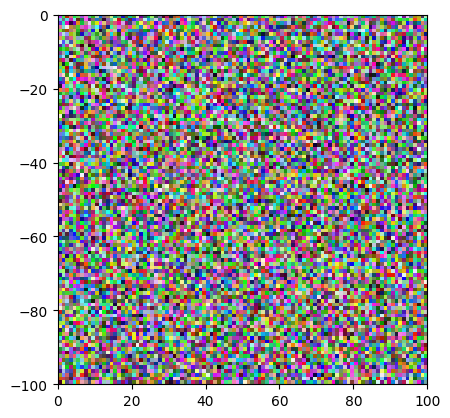

<Axes: >

In [54]:
r100_r3d = rio.open("./r100_3d.tif")
show(r100_r3d)

Excellent! Now let's make it greyscale. A simple way to do that is to average across the bands. There are at least two ways we can do that. We can explicitly read all the bands and average them

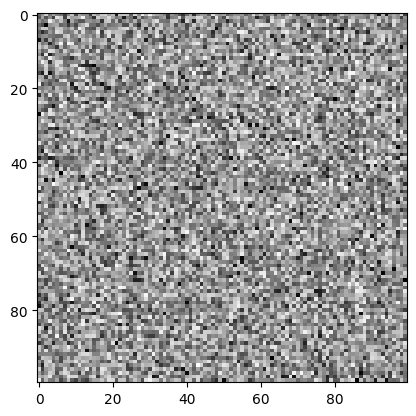

In [56]:
gs_arr = (r100_r3d.read(1)+r100_r3d.read(2)+r100_r3d.read(3))/3
plt.imshow(gs_arr, cmap="Greys")

Or we can use `numpy.mean` ([documentation](https://numpy.org/devdocs/reference/generated/numpy.mean.html)) to take the average of our original array across axis 2.

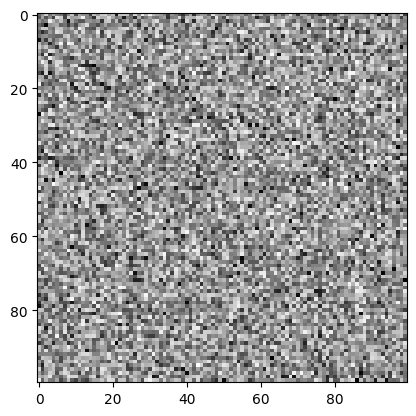

In [59]:
gs_arr2 = np.mean(r100_3,axis=2)
plt.imshow(gs_arr2, cmap="Greys")

And if we wanted to make it into a raster, we could use the same procedure as we did to make our original raster, but with the new greyscale array.

## Masking

Now that we've seen how easy band algebra is, we can do masking in one way: by using a function that returns 0 or 1 everywhere and then multplying the array by that value. For example, let's get the places where the greyscale image has a value greater than 0.5.

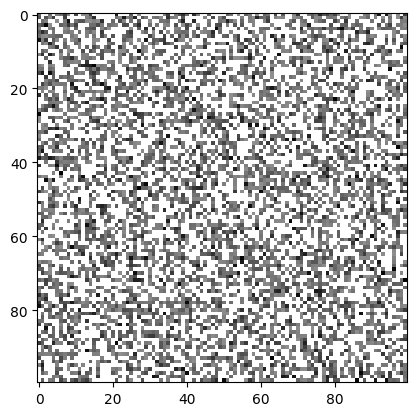

In [61]:
gs_masked1 = gs_arr*(gs_arr>0.5)
plt.imshow(gs_masked1, cmap="Greys")

And as before, we could just save this to a new raster.

The other way is to look for pixels that intersect a polygon, or multiple polygons. This requires the `rasterio.mask.mask` module ([documentation](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html)). Let's try using it on the first raster we made.

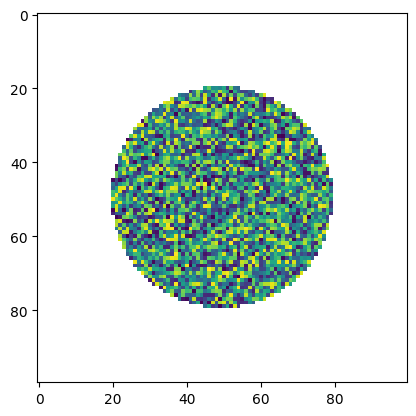

In [65]:
from rasterio.mask import mask
import shapely.geometry as shg

gs_masked2, _ = mask(r100_r,# the raster we want to mask
    [shg.Point(50,-50).buffer(30)], # We'll intersect with a circle of radius 30 centered at 50,-50. It needs to be in a list!
    nodata = np.nan # to make it more clear, we'll put nans where there isn't an intersection
    )

plt.imshow(gs_masked2[0,:,:]) # It adds a first index